# Testing de módulo `gee_objects.py`

### Imports

In [1]:
import geopandas as gpd
import ee
import os
import gee_objects as gee
import matplotlib.pyplot as plt
import pandas as pd


# ee.Authenticate()

ee.Initialize()

### CRS

In [2]:
crs_metre = '32719'
crs_degree = '4326'

### Data retrieval

In [3]:
comunas_path = os.path.join('Data', 'Comunas')
comunas = gpd.read_file(comunas_path).to_crs(crs_degree)

regiones_path = os.path.join('Data', 'Regional')
regiones = gpd.read_file(regiones_path).to_crs(crs_degree)

zonas_path = os.path.join('Data', 'dataton_zonas.gpkg')
zonas=gpd.read_file(zonas_path).to_crs(crs_degree)
petorca=zonas[zonas['zona']=='petorca']


### Data selection

In [4]:
comuna_name = 'Petorca'

comuna = {
    'name': comuna_name,
    'geometry': comunas[comunas['Comuna'] == comuna_name].geometry
}
xx, yy = comuna['geometry'].iloc[0].exterior.coords.xy
xy=[[xy[0],xy[1]] for xy in zip(xx,yy)]
aoi = ee.Geometry.Polygon(xy)

## Testing

In [5]:
geo = gee.GEERegion(comuna['geometry'], 
                    name=comuna['name'], 
                    crs=crs_degree)

dates = ('2021-01-01', '2021-12-31')
day_freq = 30

images = geo.get_images(*dates, dayfreq=day_freq, satt='Landsat-8')

indexes = ['NDVI', 'NDWI', 'NMDI', 'NDDI']
indexes = {index: geo.get_indexes(index, images) for index in indexes}


In [6]:
img_months = {i: [images[i]] + [indexes[index][i] for index in indexes]
              for i in range(len(images))}

geo.visualize(img_months[0], clip=True)

Map(center=[-32.19044545853853, -70.86993455011672], controls=(WidgetControl(options=['position', 'transparent…

In [7]:
%load_ext autoreload
%autoreload 2

# Segmentation

In [8]:
import segment

snic_obj = segment.Snic(30, 1, 4, crs_degree)
clusters = snic_obj.run(img_months[0][0], returnbands=False)

In [9]:
mean_bands = snic_obj.run(img_months[0][0], returnbands=True)

In [10]:
geo.visualize(img_months[0]+[clusters]+[mean_bands], clip=True)

Map(center=[-32.19044545853853, -70.86993455011672], controls=(WidgetControl(options=['position', 'transparent…

# Vectorization

In [11]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
bands = [f"SR_B{i}_mean" for i in range(1,8)] + ["ST_B10_mean"]

In [13]:
geo_df = snic_obj.vectorization(mean_bands, ['clusters']+bands, comuna['geometry'])

segments figure: 2425


<Axes: >

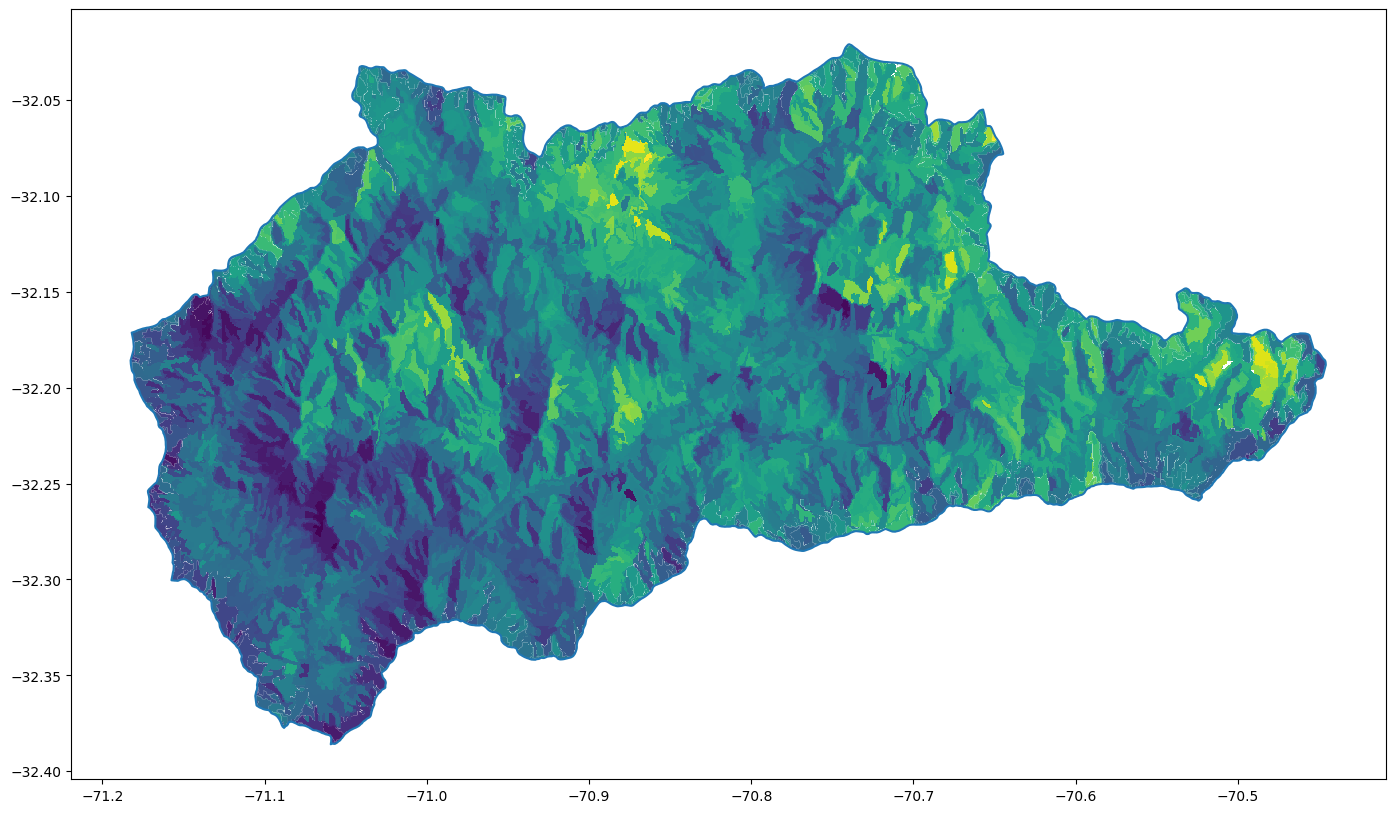

In [14]:
band = bands[0]

fig=plt.figure(figsize=(20,10))
ax=fig.add_subplot(111)

geo_df.plot(column=band, ax=ax)
comuna['geometry'].boundary.plot(ax=ax)


# KMeans Over bands B3, B4, B5


In [15]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

scaler = MinMaxScaler().fit(geo_df[bands[2:5]])
df_scaler = pd.DataFrame(scaler.transform(geo_df[bands[2:5]]))

In [16]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 4, random_state = 0, n_init='auto')
geo_df['pred_label'] = kmeans.fit_predict(df_scaler)

In [17]:
map = geo.visualize(img_months[0], clip=True)
map.add_gdf(geo_df, layer_name='pred_label', fill_colors=['red', 'yellow', 'green', 'orange'])
map

Map(center=[-32.19044545853853, -70.86993455011672], controls=(WidgetControl(options=['position', 'transparent…

<Axes: >

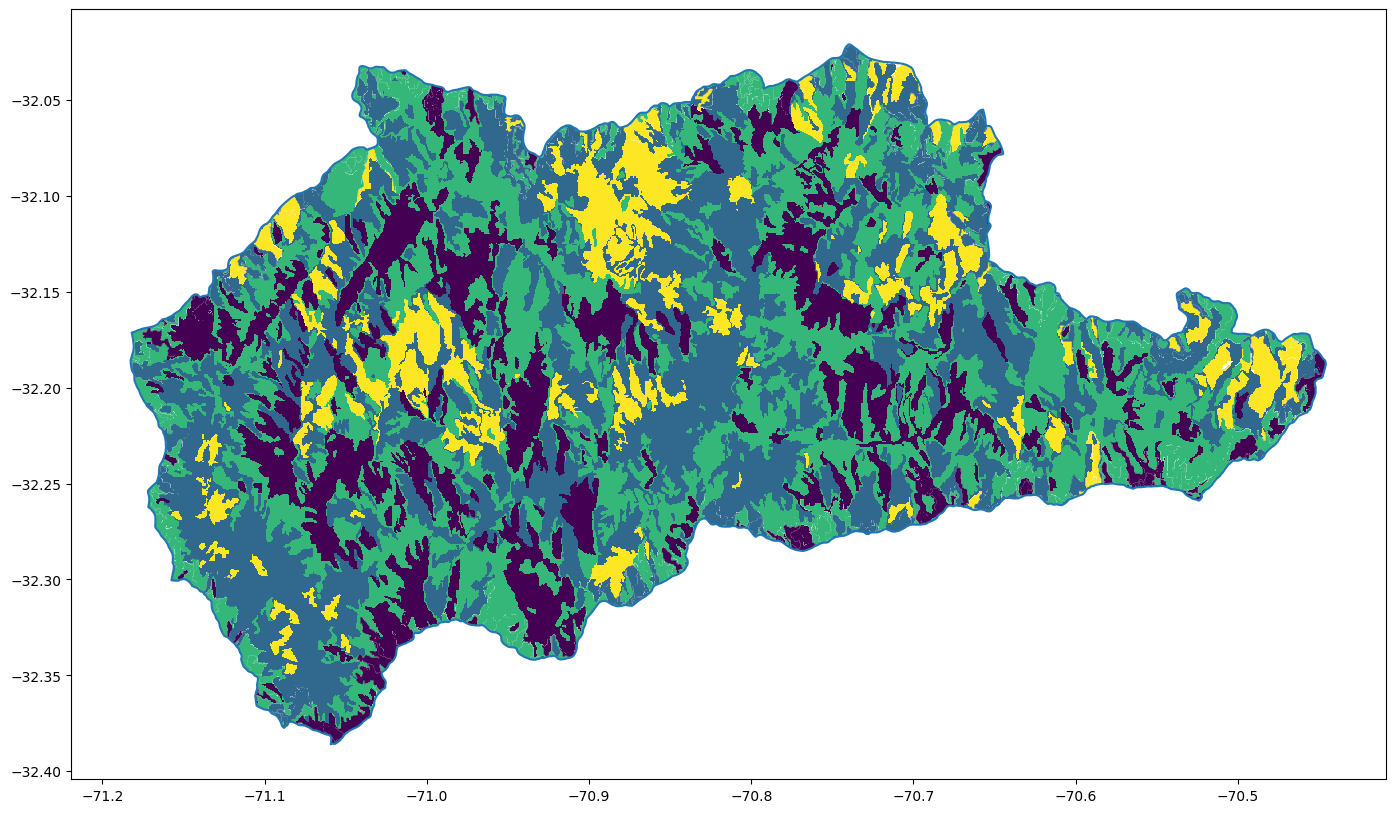

In [18]:
fig=plt.figure(figsize=(20,10))
ax=fig.add_subplot(111)

geo_df.plot(column='pred_label', ax=ax)
comuna['geometry'].boundary.plot(ax=ax)